In [21]:
# import necessary libraries

#https://codelabs.developers.google.com/codelabs/fraud-detection-ai-explanations?hl=en#0
#he Explainable AI SDK and Copy Model to Deploy

#https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/solutions/preprocessing_layers.ipynb
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/custom-tabular-bq-managed-dataset.ipynb
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/experiments/comparing_local_trained_models.ipynb


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,DenseFeatures

from datetime import date, timedelta, datetime # Date Functions
import time


from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# from google.cloud import aiplatform as vertex_ai
from tensorflow.python.keras.utils import data_utils

tf.__version__

'2.12.0'

In [22]:
#cateCols=['sla','product_type','brand','service_type','incident_type']
cateCols=['sla','product_type','service_type','incident_type']

#numbericCols=['open_to_close_hour','response_to_resolved_hour']
numbericCols=['open_to_close_hour']

unusedCols=['severity_id','severity_name','label_binary_severity','response_to_resolved_hour','brand']
labelCol='label_multi_severity'

main_metric='accuracy'
main_objective=f'val_{main_metric}'


objective_to_tued_and_monitor='val_loss' 
# objective_to_tued_and_monitor=main_objective

seed=1932

EPOCHS =50
BATCH_SIZE = 32

unitList=[32,64,128]
dropOutList= [0.1, 0.2]
# lrList=[0.01,0.001]
nMax_trials=10
nExecutions_per_trial=5
nEarlyPatience=11

model_tuned_dir='tuned_model'

# df['label_multi_severity'] =df['severity_name'].map({'Cosmatic':0,'Minor': 1, "Major": 2, "Critical": 3}) 

# Load Data

In [23]:
projectId='pongthorn'
client = bigquery.Client(project=projectId)
dataset_id='SMartML'

train_name='train_incident'
validation_name='validation_incident'
test_name='test_incident'

train_table_id=f"{projectId}.{dataset_id}.{train_name}"
val_tabel_id=f"{projectId}.{dataset_id}.{validation_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"

In [24]:
# def load_ml_data(data_path):
#  df=pd.read_csv(data_path)
#  df =df.drop(columns=unusedCols)
#  return df

# root_path='../../data'    
# train = load_ml_data(f"{root_path}/train_incident.csv")
# # val=train.copy()
# val=load_ml_data(f"{root_path}/validation_incident.csv")
# # test =val.copy()
# test =load_ml_data(f"{root_path}/test_incident.csv")

def load_data_bq(sql:str):
 
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 df =df.drop(columns=unusedCols)
  
 return df
    

train=load_data_bq(f"SELECT * FROM {train_table_id}")
val=load_data_bq(f"SELECT * FROM {val_tabel_id}")
test=load_data_bq(f"SELECT * FROM {test_tabel_id}")

print(train.shape)
print(val.shape)
print(test.shape)


labelList=list(train[labelCol].unique())
print(labelList)
nLabel=len(labelList)
print(f"No target label : {nLabel}")

# sr_predict=df.iloc[-1,:]
# df=df.iloc[0:len(df)-1,:]
                 
print(train.info())
train.tail()

(2731, 6)
(341, 6)
(342, 6)
[2, 1, 0, 3]
No target label : 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2731 entries, 0 to 2730
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sla                   2731 non-null   object 
 1   product_type          2731 non-null   object 
 2   service_type          2731 non-null   object 
 3   incident_type         2731 non-null   object 
 4   open_to_close_hour    2731 non-null   float64
 5   label_multi_severity  2731 non-null   Int64  
dtypes: Int64(1), float64(1), object(4)
memory usage: 130.8+ KB
None


,sla,product_type,service_type,incident_type,open_to_close_hour,label_multi_severity
2726,24x7 4Hrs Response Time,Security,Request,General Incident,0.333333,0
2727,24x7 6Hrs Resolution Time,Software,Request,General Incident,0.883333,0
2728,24x7 4Hrs Response Time,Security,Request,OS / Firmware,16.666667,0
2729,24x7 4Hrs Response Time,Software,Request,General Incident,7.400000,0
2730,24x7 6Hrs Resolution Time,Software,Request,General Incident,5.483333,0


In [25]:
def CalPctEachTargetClass(dfx,colSev,colPctSev):
    dfClassSummary=dfx.groupby([labelCol]).size().to_frame(colSev)
    dfClassSummary[colPctSev]= dfClassSummary[colSev]/dfClassSummary[colSev].sum() *100
    dfClassSummary=dfClassSummary.round(0)
    return dfClassSummary

pctDF1=CalPctEachTargetClass(train,'Train-No-Severity','Train-%-Severity')
pctDF2=CalPctEachTargetClass(val,'Val-No-Severity','Val-%-Severity')
pdcDF3=CalPctEachTargetClass(test,'Test-No-Severity','Test-%-Severity')
pctDF=pd.concat([pctDF1,pctDF2,pdcDF3],axis=1)

pctDF

,Train-No-Severity,Train-%-Severity,Val-No-Severity,Val-%-Severity,Test-No-Severity,Test-%-Severity
label_multi_severity,,,,,,
0,511,19.0,53,16.0,55,16.0
1,778,28.0,97,28.0,92,27.0
2,1341,49.0,180,53.0,181,53.0
3,101,4.0,11,3.0,14,4.0


# Process Data  Layer

In [12]:
def multiple_label_df_to_dataset(dataframe, shuffle=True, batch_size=32):
  features = dataframe.copy()
  labels = features.pop(labelCol)
  labels  = tf.keras.utils.to_categorical(labels, num_classes=nLabel)
    
  ds = tf.data.Dataset.from_tensor_slices(( dict(features), labels ))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(features))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds
     
     

In [13]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [14]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))
     

In [15]:
batch_size =32
train_ds = multiple_label_df_to_dataset (train, batch_size=batch_size)
val_ds = multiple_label_df_to_dataset(val, batch_size=batch_size)
test_ds = multiple_label_df_to_dataset(test, batch_size=batch_size)
# for element in train_ds.as_numpy_iterator():
#     print(element)

In [19]:
all_inputs = []
encoded_features = []
numInputFeatToInitNodeUnit=0
# Numeric features.
for header in numbericCols:
  print(header)  
  stat_data=train[header].describe()
  print(f"header: Mean={stat_data['mean']} and Std={stat_data['std']}") 
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)
  print("========================================================================"  
    
numInputFeatToInitNodeUnit=numInputFeatToInitNodeUnit+len(numbericCols)
 
# Categorical features encoded as string.
categorical_cols = cateCols
for header in categorical_cols:
    
  listCateItem=train[header].unique()
  noCateItem=len(listCateItem)
  numInputFeatToInitNodeUnit=numInputFeatToInitNodeUnit+noCateItem +1  # last 1 is unknow  
  print(f"{header} = {noCateItem} : {listCateItem}")    
    
  print(header)  
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string')
                                        
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


open_to_close_hour
header: Mean=120.7417429512999 and Std=339.9325107996055
sla = 7 : ['24x7 4Hrs Resolution Time' '24x7 4Hrs Response Time'
 '24x7 6Hrs Resolution Time' '8x5 4Hrs Response Time'
 '9x5 NBD 4Hrs Response Time' '24x7 6Hrs Response Time' 'Non MA']
sla
product_type = 13 : ['Other' 'Printer' 'Storage' 'Software' 'Server' 'Access Point' 'Switch'
 'Hardware' 'Tape Library' 'Security' 'Service' 'Notebook' 'Firewall']
product_type
service_type = 2 : ['Incident' 'Request']
service_type
incident_type = 21 : ['General Incident' 'Network Adapter Failure' 'Software'
 'Maintenance System' 'Hard Disk Drive Failure' 'Power Supply Failure'
 'Report' 'System Board Failure' 'Memory Failure' 'Network Card Failure'
 'Controller/Node Failure' 'Backup Failure' 'Upgrade Software'
 'CPU Failure' 'OS / Firmware' 'Configuration Change'
 'Cache Battery Failure' 'Other Failure' 'Network Cable Failure'
 'Battery Failure' 'Fan Failure']
incident_type


# Tune HyperParameter By Keras Tuner

In [71]:
#https://github.com/technqvi/TimeSeriesML-FinMarket/blob/main/lstm-tune-dev/Tuned-MultiVarToManyOutputLSTM.ipynb
#https://www.tensorflow.org/tutorials/keras/keras_tuner
#https://keras.io/guides/keras_tuner/getting_started/
import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters

tune_folder="IncidentMLP"

In [72]:
t_Start=time.time()

print(f"Start tund at {datetime.now()}")
print("=============================================================")
buildtime = datetime.now().strftime('%d%m%y_%H%M')
project_model=f"{tune_folder}_{buildtime}"
print(project_model)

Start tund at 2023-07-20 12:51:02.730211
IncidentMLP_200723_1251


In [73]:
def build_model_for_tuning(hp):
    
    all_features = tf.keras.layers.concatenate(encoded_features)
    
    x = tf.keras.layers.Dense(hp.Choice('units', unitList), activation="relu")(all_features)
    
    x = tf.keras.layers.Dropout(hp.Choice('Dropout_rate',dropOutList))(x)
    
    output = tf.keras.layers.Dense(nLabel,activation=tf.nn.softmax)(x)
    
    model = tf.keras.Model(all_inputs, output)
    model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[main_metric])
    
    # hp_learning_rate = hp.Choice('learning_rate', values=lrList) 
    # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
    #               loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[main_metric])
    return model

In [74]:
tuner = kt.BayesianOptimization(
## tuner = kt.Hyperband(
# tuner = keras_tuner.RandomSearch(  #main_objective
    build_model_for_tuning, objective=objective_to_tued_and_monitor,seed=seed,
    max_trials=nMax_trials,executions_per_trial=nExecutions_per_trial,
    directory=f"tuning/{tune_folder}/",project_name= project_model)

stop_early = tf.keras.callbacks.EarlyStopping(monitor=objective_to_tued_and_monitor, patience=nEarlyPatience)
tuner.search(train_ds, batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=val_ds,callbacks=[stop_early])
    


Trial 10 Complete [00h 00m 37s]
val_loss: 0.7139382759730021

Best val_loss So Far: 0.7059268951416016
Total elapsed time: 00h 07m 08s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [75]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'units': 150, 'Dropout_rate': 0.2}


In [76]:
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execution : ',round(t_elapsed,2)) 
print(datetime.now())
print("=============================================================")

Total execution :  0.12
2023-07-20 12:58:10.655924


# Retain by best model to product model to production

In [77]:
print("Build the model with the optimal hyperparameters and train it on the data to find  N epochs")
best_model = tuner.hypermodel.build(best_hps)
# model.summary()
history = best_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, batch_size=BATCH_SIZE)

Build the model with the optimal hyperparameters and train it on the data to find  N epochs
Epoch 1/50
70/70 [==============================] - 4s 19ms/step - loss: 1.0439 - accuracy: 0.5523 - val_loss: 0.8705 - val_accuracy: 0.6751
Epoch 2/50
70/70 [==============================] - 0s 7ms/step - loss: 0.8077 - accuracy: 0.6830 - val_loss: 0.7854 - val_accuracy: 0.6643
Epoch 3/50
70/70 [==============================] - 1s 8ms/step - loss: 0.7451 - accuracy: 0.6876 - val_loss: 0.7561 - val_accuracy: 0.6715
Epoch 4/50
70/70 [==============================] - 1s 8ms/step - loss: 0.7174 - accuracy: 0.7051 - val_loss: 0.7441 - val_accuracy: 0.6823
Epoch 5/50
70/70 [==============================] - 1s 8ms/step - loss: 0.6986 - accuracy: 0.7110 - val_loss: 0.7300 - val_accuracy: 0.6715
Epoch 6/50
70/70 [==============================] - 1s 8ms/step - loss: 0.6827 - accuracy: 0.7205 - val_loss: 0.7333 - val_accuracy: 0.6859
Epoch 7/50
70/70 [==============================] - 1s 8ms/step - l

In [81]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(f'Best epoch: {best_epoch}')

Best epoch: 43


In [82]:
print("Fid Optimal Best Epoch  by Re-instantiating the hypermodel and train it")
model = tuner.hypermodel.build(best_hps)
# Retrain the model to get final
history_hypermodel=model.fit(train_ds, validation_data=val_ds, epochs=best_epoch)

val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Eveluation on Val-Data at {best_epoch} epochs : loss={val_loss} and {main_metric}= {val_accuracy}")
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Evaluation on Test-Data at {best_epoch} epochs : loss={test_loss} and {main_metric}= {test_accuracy}")

Fid Optimal Best Epoch  by Re-instantiating the hypermodel and train it
Epoch 1/43
70/70 [==============================] - 3s 12ms/step - loss: 1.0681 - accuracy: 0.5189 - val_loss: 0.8786 - val_accuracy: 0.7184
Epoch 2/43
70/70 [==============================] - 0s 5ms/step - loss: 0.8185 - accuracy: 0.6740 - val_loss: 0.7811 - val_accuracy: 0.6643
Epoch 3/43
70/70 [==============================] - 0s 5ms/step - loss: 0.7489 - accuracy: 0.7024 - val_loss: 0.7602 - val_accuracy: 0.6751
Epoch 4/43
70/70 [==============================] - 0s 5ms/step - loss: 0.7186 - accuracy: 0.7029 - val_loss: 0.7353 - val_accuracy: 0.6679
Epoch 5/43
70/70 [==============================] - 0s 5ms/step - loss: 0.6957 - accuracy: 0.7205 - val_loss: 0.7203 - val_accuracy: 0.6679
Epoch 6/43
70/70 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.7110 - val_loss: 0.7290 - val_accuracy: 0.6823
Epoch 7/43
70/70 [==============================] - 0s 5ms/step - loss: 0.6744 - accura

4#Explore Result model


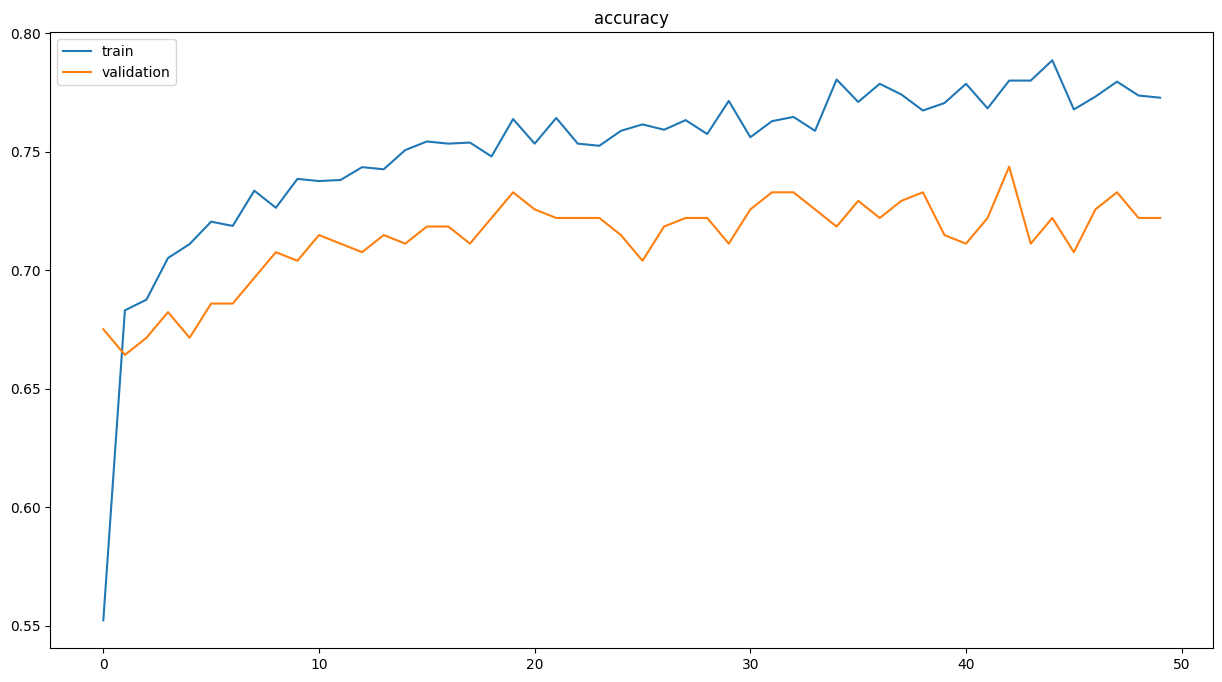

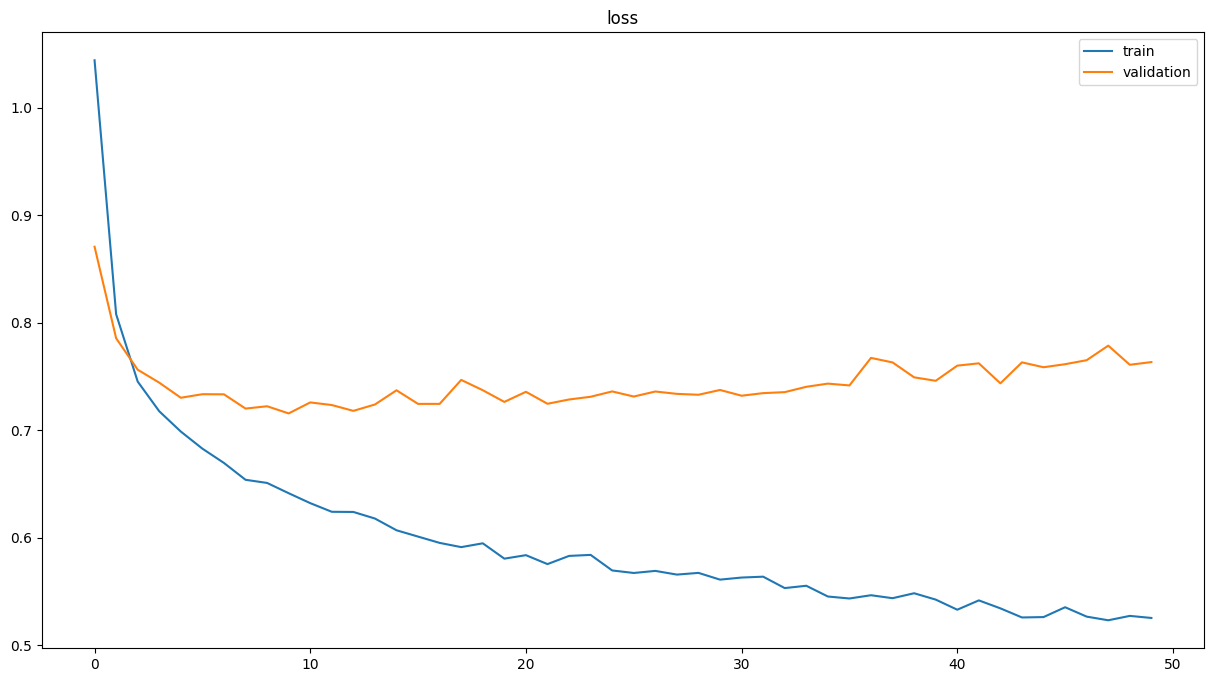

In [84]:
def plot_metrics(history,metric):
    plt.figure(figsize=(15,8))
    plt.title(metric)
    plt.plot(history.history[metric], label='train')
    plt.plot(history.history[f'val_{metric}'], label='validation')
    plt.legend()
    plt.show() 

print("4#Explore Result model")
plot_metrics(history,main_metric)
plot_metrics(history,"loss")


In [85]:
model.save(model_tuned_dir)
# quit()

INFO:tensorflow:Assets written to: tuned_model\assets


INFO:tensorflow:Assets written to: tuned_model\assets


In [86]:
reloaded_model = tf.keras.models.load_model(model_tuned_dir)
#label_multi_severity
sample={"sla":"24x7 4Hrs Response Time",
        "product_type":"Server",
        "brand":"VMWare",                
        "service_type":"Incident",
        "incident_type":"General Incident",
        "open_to_close_hour":10,
        "response_to_resolved_hour":8.000000 \
       }

print(sample)
              
print("===============================================================================================================")    
print("convert pain data to serdor as input to predict")    
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
print(input_dict)

predictionList = reloaded_model.predict(input_dict)
print(predictionList)
prob = tf.nn.sigmoid(predictionList[0])
print(f"{(100 * prob)} %  as Severity") 

{'sla': '24x7 4Hrs Response Time', 'product_type': 'Server', 'brand': 'VMWare', 'service_type': 'Incident', 'incident_type': 'General Incident', 'open_to_close_hour': 10, 'response_to_resolved_hour': 8.0}
convert pain data to serdor as input to predict
{'sla': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'24x7 4Hrs Response Time'], dtype=object)>, 'product_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Server'], dtype=object)>, 'brand': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'VMWare'], dtype=object)>, 'service_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Incident'], dtype=object)>, 'incident_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'General Incident'], dtype=object)>, 'open_to_close_hour': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([10])>, 'response_to_resolved_hour': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([8.], dtype=float32)>}
1/1 [==============================] - 1s 529ms/step
[[0.00572414 0.1736307

# Copy Model From Local To GCS

In [94]:
# #https://codelabs.developers.google.com/codelabs/fraud-detection-ai-explanations?hl=en#6
# press_y3=input(f"Press y=True to save model to Google Cloud storage : ") 
# if press_y3.lower()=='y':
#     MODEL_BUCKET = 'gs://tf1-incident-pongthorn'
#     MODEL_NAME = 'tf1_incident_multi_model'

# # !gsutil mb -l $REGION $MODEL_BUCKET
# # !gsutil -m cp -r ./$model_tuned_dir/* $MODEL_BUCKET/model
# else:
#  quite()


Copying file://.\model\saved_model.pb [Content-Type=application/octet-stream]...
Copying file://.\model\variables\variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/527.8 KiB]   0% Done                                    
/ [0/5 files][    0.0 B/527.8 KiB]   0% Done                                    
Copying file://.\model\fingerprint.pb [Content-Type=application/octet-stream]...
Copying file://.\model\keras_metadata.pb [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/527.8 KiB]   0% Done                                    
/ [0/5 files][    0.0 B/527.8 KiB]   0% Done                                    
Copying file://.\model\variables\variables.index [Content-Type=application/octet-stream]...
/ [0/5 files][    0.0 B/527.8 KiB]   0% Done                                    
/ [1/5 files][ 97.0 KiB/527.8 KiB]  18% Done                                    
/ [2/5 files][ 97.0 KiB/527.8 KiB]  18% Done                          

# Import Model to Vertex AI

In [ ]:
# https://cloud.google.com/vertex-ai/docs/model-registry/import-model#get-operation

#https://codelabs.developers.google.com/vertex-p2p-predictions#3
# Import model manually
#https://console.cloud.google.com/vertex-ai/models?project=pongthorn
# Upload wand wait for vertex to complete process (Email notification)
# if run package ( you need to specify precuild-pacage


#Import model programactically
# https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers

# from google.cloud import aiplatform
# DEPLOY_IMAGE = "asia-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-6:latest"

# model = aip.Model.upload(
#     display_name="ponghthorn_xgb_" + TIMESTAMP,
#     artifact_uri=MODEL_DIR,
#     serving_container_image_uri=DEPLOY_IMAGE,
#     sync=False,
# )

# model.wait()


# Deploy Model to EndPoint

In [ ]:
#https://codelabs.developers.google.com/vertex-p2p-predictions#4
# Manual

# Program
# my_model = aiplatform.Model("projects/{PROJECT_NUMBER}/locations/us-central1/models/{MODEL_ID}") 

# endpoint = my_model.deploy(
#      deployed_model_display_name='my-endpoint',
#      traffic_split={"0": 100},
#      machine_type="n1-standard-4",
#      accelerator_count=0,
#      min_replica_count=1,
#      max_replica_count=1,
#    )

In [95]:
# Deploy to AIPlatform (Deprecated)
# MODEL = MODEL_NAME
# VERSION = 'v1'
# model_path = MODEL_BUCKET + '/model'

# # !gcloud ai-platform models create $MODEL --region=$REGION

# MACHINE_TYPE='n1-standard-2'

# !gcloud  ai-platform versions create $VERSION --model $MODEL --origin $model_path --runtime-version 2.11 --framework TENSORFLOW --machine-type $MACHINE_TYPE --python-version 3.7 --region=$REGION
# !gcloud ai-platform versions describe $VERSION --model $MODEL --region=$REGION